In [28]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F

sys.path.append('..')
# Slowfast imports
from slowfast.models import build_model
from slowfast.utils.parser import alt_parse_args, load_config

plt.style.use(["science", "high-vis"])

In [29]:
# Load the model
path_to_config = "/home/kukushkin/imslowfast/configs/SLOW_8x8_R50_Local_max.yaml"
path_to_ckpt = "/home/kukushkin/imslowfast/weights/checkpoint_epoch_00200.pyth"

with open(
    "/home/kukushkin/imslowfast/dataset/metadata/behaviours.txt",
    "rb",
) as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

args = alt_parse_args()[:-1]
cfg = load_config(
    args[0],
    path_to_config=path_to_config,
)
checkpoint = torch.load(path_to_ckpt, map_location="cpu")

model = build_model(cfg)
model.load_state_dict(checkpoint["model_state"])
model.eval()
model.cpu()

classifier = model.head.projection


In [30]:
fg_fewshot = pd.read_pickle(
    "/home/kukushkin/imslowfast/dataset/logits/fg_fewshot_for_maskim.pkl"
)
bg_fewshot = pd.read_pickle(
    "/home/kukushkin/imslowfast/dataset/logits/bg_fewshot_for_maskim.pkl"
)

def extract_frame_wise_features(feature_map, t):
    spatially_pooled = F.adaptive_avg_pool3d(feature_map, (t, 1, 1))
    frame_wise_features = torch.flatten(spatially_pooled, start_dim=2)
    return frame_wise_features

#torch.Size([1, 2048, 16, 8, 8])
def swap_frames(sample):
    # Slice the sample only once, store the slices in variables
    frames = torch.split(sample, 4, dim=2)
    
    # Swap the frames and concatenate them in reverse order
    sample_swapped = torch.cat(frames[::-1], dim=2)
    
    return sample_swapped



In [31]:
sample_idx = 10

fg_sample = fg_fewshot.feat_map.iloc[sample_idx]
bg_sample = bg_fewshot.feat_map.iloc[sample_idx]

# swap frames
fg_sample_swapped = fg_sample.clone()
fg_sample_swapped = swap_frames(fg_sample_swapped)

bg_sample_swapped = bg_sample.clone()
bg_sample_swapped = swap_frames(bg_sample_swapped)



# Compute cosine similarity between the two samples
fg_framewise_features = extract_frame_wise_features(fg_sample, t=16)
fg_framewise_features_swapped = extract_frame_wise_features(fg_sample_swapped, t=16)
bg_framewise_features = extract_frame_wise_features(bg_sample, t=16)
bg_framewise_features_swapped = extract_frame_wise_features(bg_sample_swapped, t=16)

# Squeeze and permute the dimensions
fg_framewise_features = fg_framewise_features.squeeze(0)
fg_framewise_features_swapped = fg_framewise_features_swapped.squeeze(0)
fg_framewise_features = fg_framewise_features.T
fg_framewise_features_swapped = fg_framewise_features_swapped.T

bg_framewise_features = bg_framewise_features.squeeze(0)
bg_framewise_features_swapped = bg_framewise_features_swapped.squeeze(0)
bg_framewise_features = bg_framewise_features.T
bg_framewise_features_swapped = bg_framewise_features_swapped.T


# Compute framewise logits
fg_frame_wise_logits = []
for feat in fg_framewise_features.squeeze(0):
    fg_frame_wise_logits.append(torch.sigmoid(classifier(feat).detach()).numpy())
fg_frame_wise_logits = np.array(fg_frame_wise_logits)

fg_frame_wise_logits_swapped = []
for feat in fg_framewise_features_swapped.squeeze(0):
    fg_frame_wise_logits_swapped.append(torch.sigmoid(classifier(feat).detach()).numpy())
fg_frame_wise_logits_swapped = np.array(fg_frame_wise_logits_swapped)


bg_frame_wise_logits = []
for feat in bg_framewise_features.squeeze(0):
    bg_frame_wise_logits.append(torch.sigmoid(classifier(feat).detach()).numpy())
bg_frame_wise_logits = np.array(bg_frame_wise_logits)

bg_frame_wise_logits_swapped = []
for feat in bg_framewise_features_swapped.squeeze(0):
    bg_frame_wise_logits_swapped.append(torch.sigmoid(classifier(feat).detach()).numpy())
bg_frame_wise_logits_swapped = np.array(bg_frame_wise_logits_swapped)

fg_video_level_features = F.adaptive_avg_pool3d(fg_sample, output_size=(1, 1, 1))
fg_video_level_features = torch.flatten(fg_video_level_features, start_dim=1)

fg_video_level_features_swapped = F.adaptive_avg_pool3d(fg_sample_swapped, output_size=(1, 1, 1))
fg_video_level_features_swapped = torch.flatten(fg_video_level_features_swapped, start_dim=1)



fg_video_level_logits = (
    torch.sigmoid(classifier(fg_video_level_features)).detach().numpy()
)
fg_video_level_logits = np.array(fg_video_level_logits)

fg_video_level_logits_swapped = (
    torch.sigmoid(classifier(fg_video_level_features_swapped)).detach().numpy()
)
fg_video_level_logits_swapped = np.array(fg_video_level_logits_swapped)


bg_video_level_features = F.adaptive_avg_pool3d(bg_sample, output_size=(1, 1, 1))
bg_video_level_features = torch.flatten(bg_video_level_features, start_dim=1)

bg_video_level_logits = (
    torch.sigmoid(classifier(bg_video_level_features)).detach().numpy()
)
bg_video_level_logits = np.array(bg_video_level_logits)

bg_video_level_features_swapped = F.adaptive_avg_pool3d(bg_sample_swapped, output_size=(1, 1, 1))
bg_video_level_features_swapped = torch.flatten(bg_video_level_features_swapped, start_dim=1)

bg_video_level_logits_swapped = (
    torch.sigmoid(classifier(bg_video_level_features_swapped)).detach().numpy()
)
bg_video_level_logits_swapped = np.array(bg_video_level_logits_swapped)


In [32]:
fg_frame_wise_logits.shape

(16, 14)

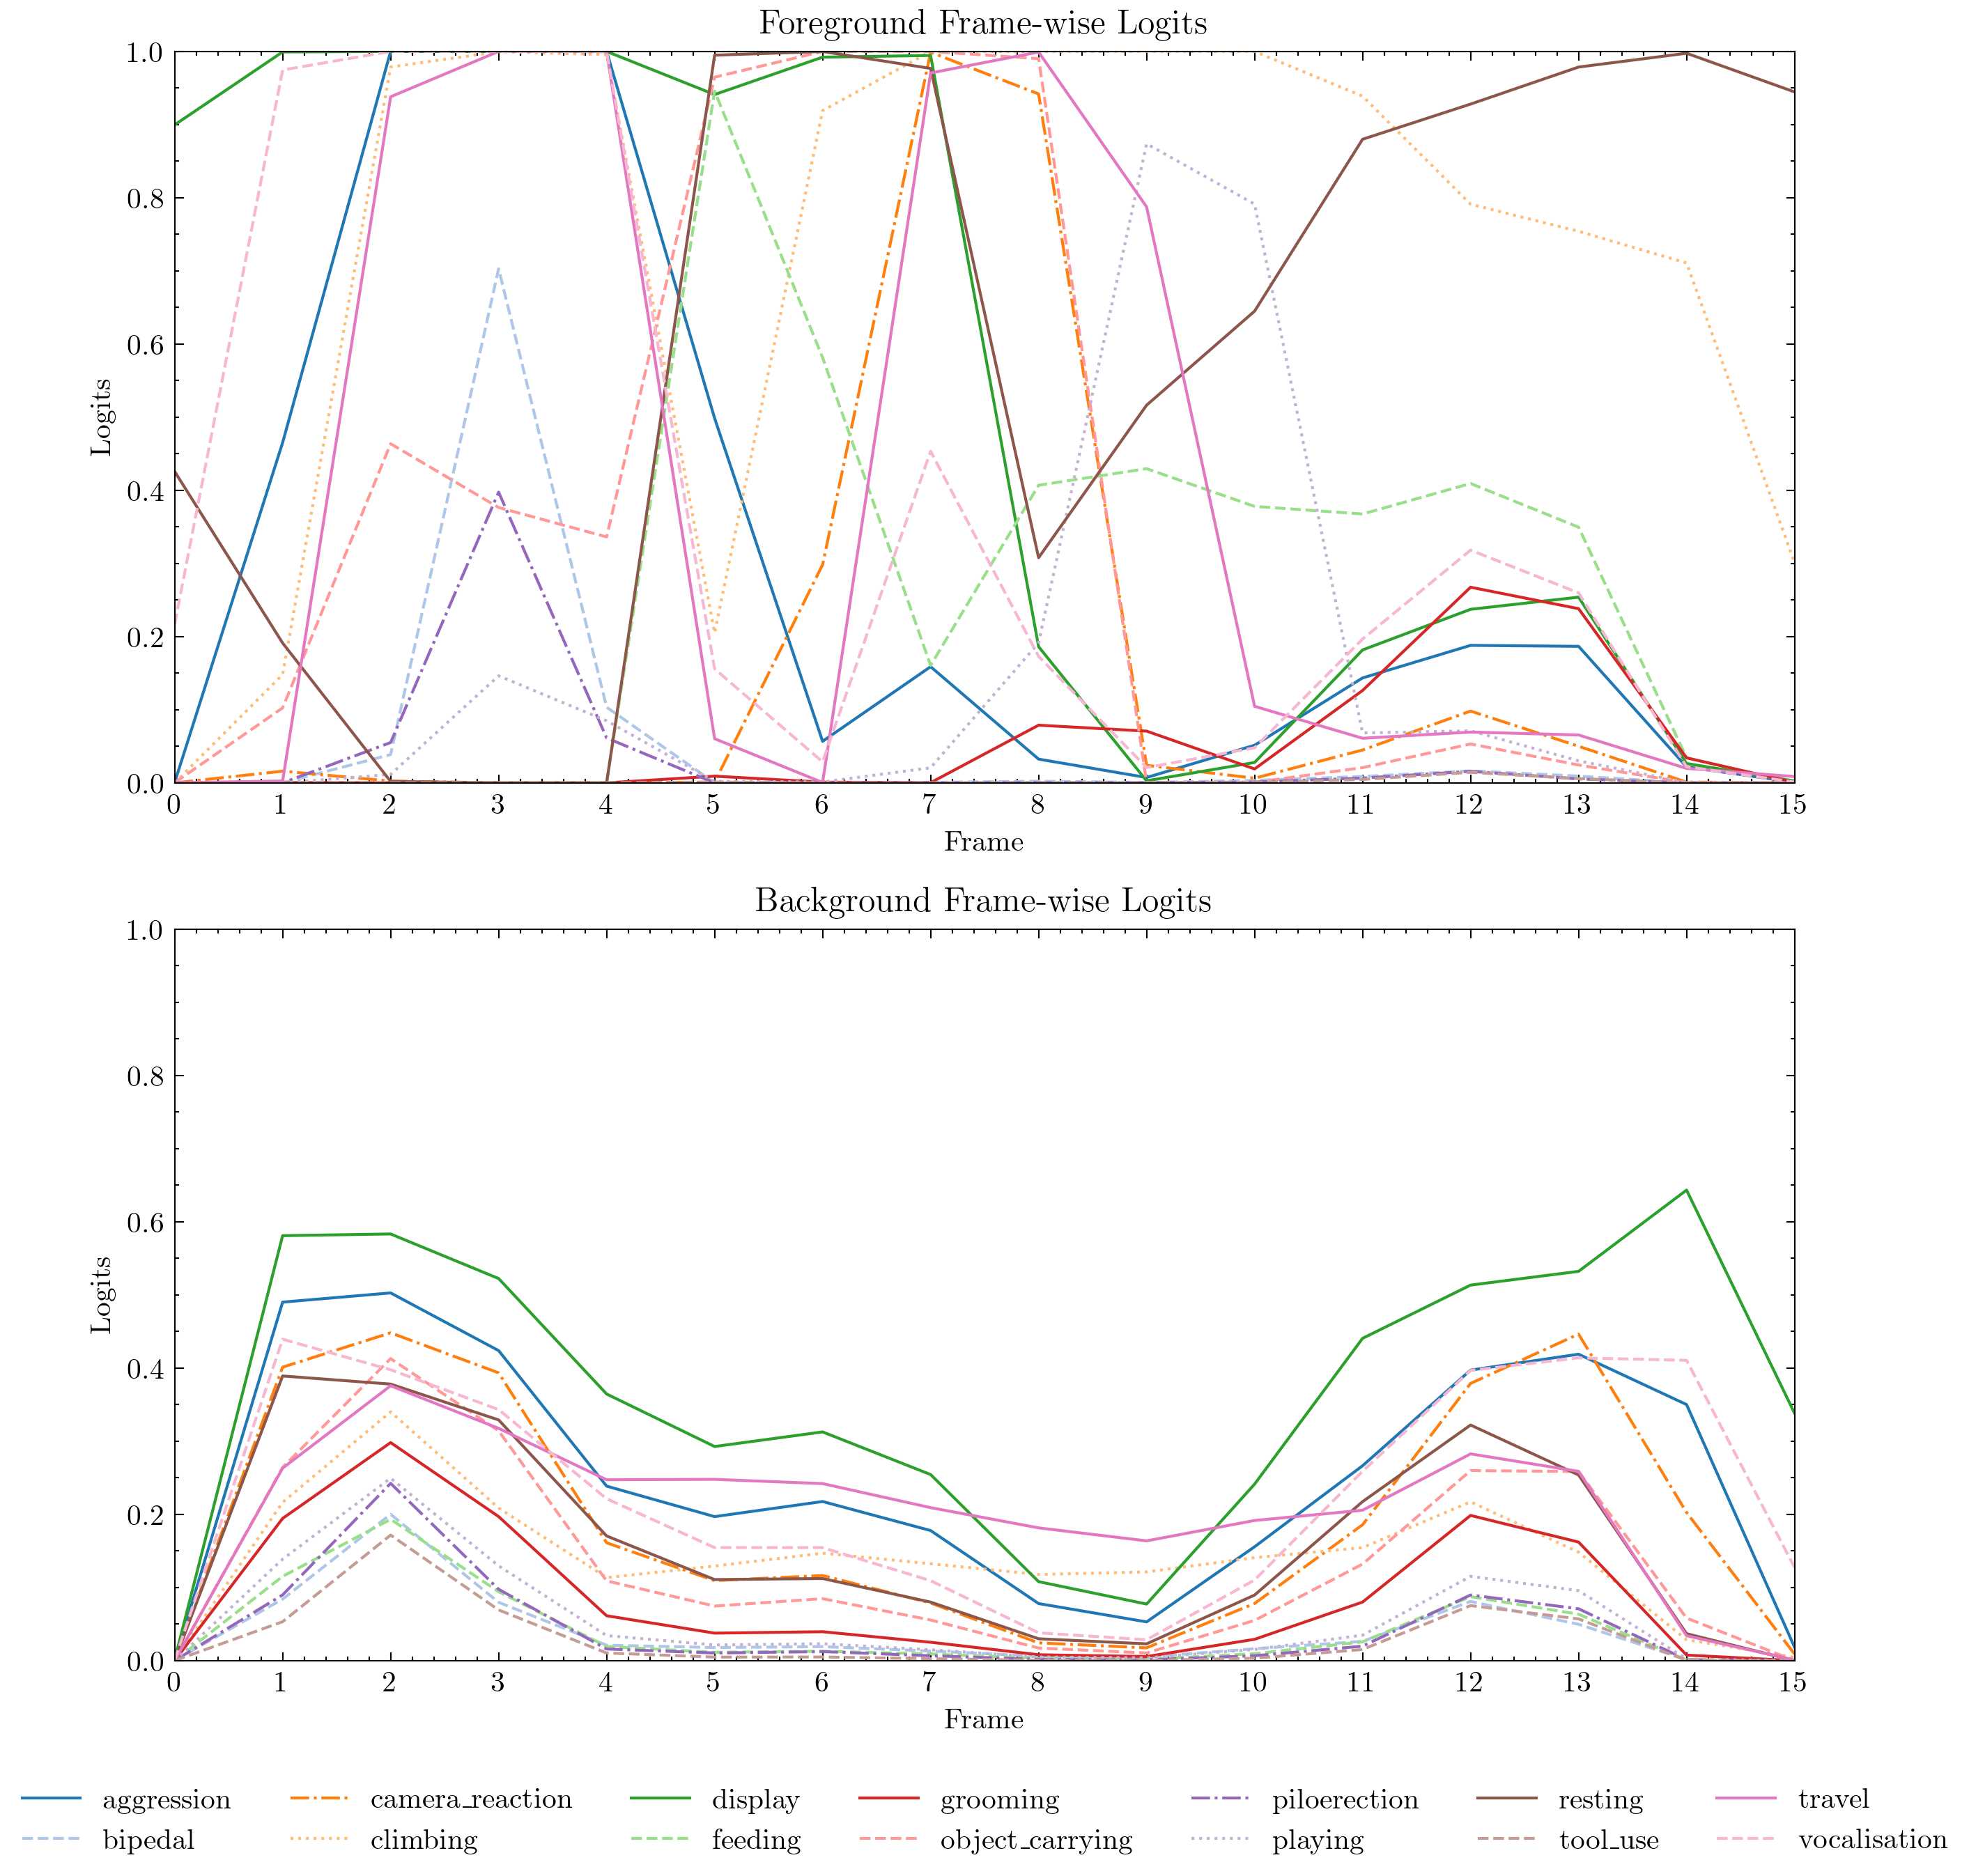

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=300)


cmap = sns.color_palette("tab20", n_colors=14)
# plot distribution of logits along 3rd dimension

for i, beh in enumerate(behaviours):
    ax[0].plot(fg_frame_wise_logits[:, i], color=cmap[i], label=beh)
    ax[1].plot(bg_frame_wise_logits[:, i], color=cmap[i], label=beh)

ax[0].set_xlabel("Frame")
ax[0].set_ylabel("Logits")
ax[0].set_title("Foreground Frame-wise Logits")

ax[1].set_xlabel("Frame")
ax[1].set_ylabel("Logits")
ax[1].set_title("Background Frame-wise Logits")

# add legend with behaviour names under the plot
ax[1].legend(behaviours, loc="lower center", ncol=7, bbox_to_anchor=(0.5, -0.3))


ax[0].set_xlim(0, 15)
ax[1].set_xlim(0, 15)
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)

# set xticks
ax[0].set_xticks(np.arange(0, 16, 1))
ax[1].set_xticks(np.arange(0, 16, 1))

plt.show()

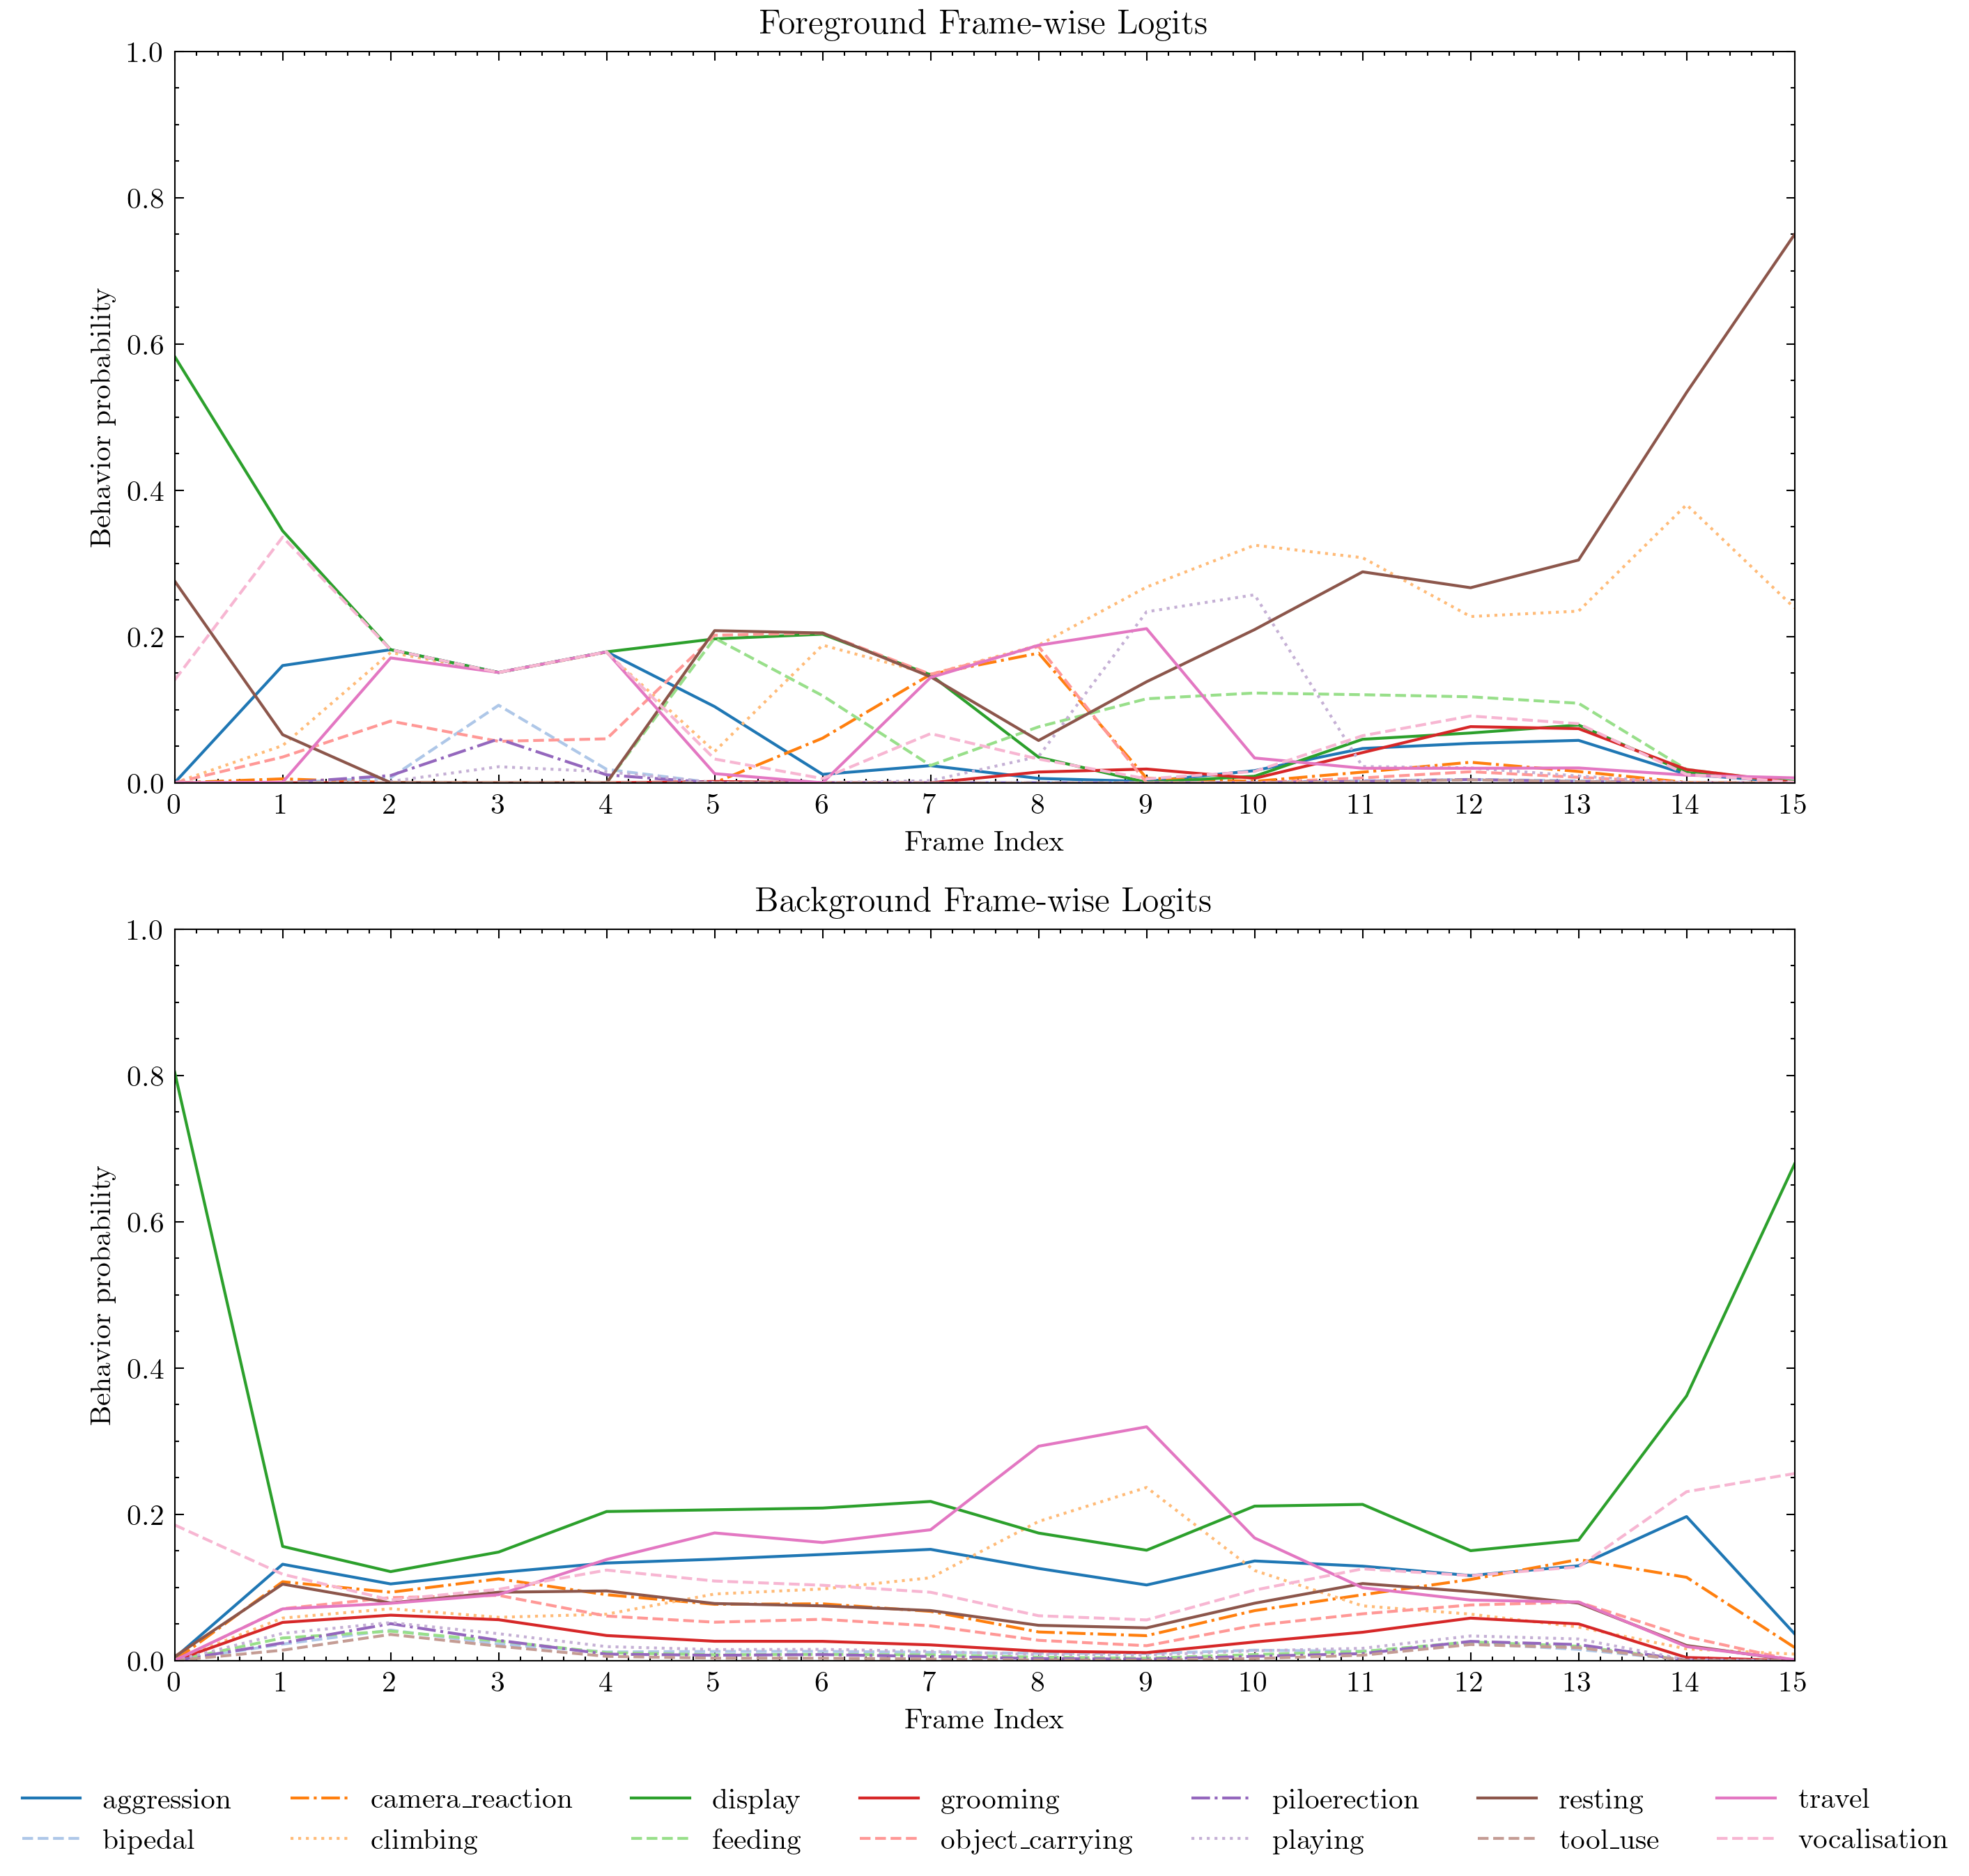

In [34]:
fg_column_sum = np.sum(fg_frame_wise_logits, 1)
bg_column_sum = np.sum(bg_frame_wise_logits, 1)

# divide the value of each element by the sum of the row
normalized_fg_frame_wise_logits = fg_frame_wise_logits / fg_column_sum[:, None]
normalized_bg_frame_wise_logits = bg_frame_wise_logits / bg_column_sum[:, None]

fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=300)

# plot fg
for i, beh in enumerate(behaviours):
    ax[0].plot(normalized_fg_frame_wise_logits[:, i], color=cmap[i], label=beh)
    ax[1].plot(normalized_bg_frame_wise_logits[:, i], color=cmap[i], label=beh)

ax[0].set_title("Foreground Frame-wise Logits")
ax[0].set_ylabel("Behavior probability")
ax[0].set_xlabel("Frame Index")
ax[0].set_xlim(0, 15)
ax[0].set_ylim(0, 1)
ax[0].set_xticks(np.arange(0, 16, 1))

ax[1].set_title("Background Frame-wise Logits")
ax[1].set_ylabel("Behavior probability")
ax[1].set_xlabel("Frame Index")

# add legend with behaviour names under the plot
ax[1].legend(behaviours, loc="lower center", ncol=7, bbox_to_anchor=(0.5, -0.3))

ax[1].set_xlim(0, 15)
ax[1].set_ylim(0, 1)
ax[1].set_xticks(np.arange(0, 16, 1))

plt.show()


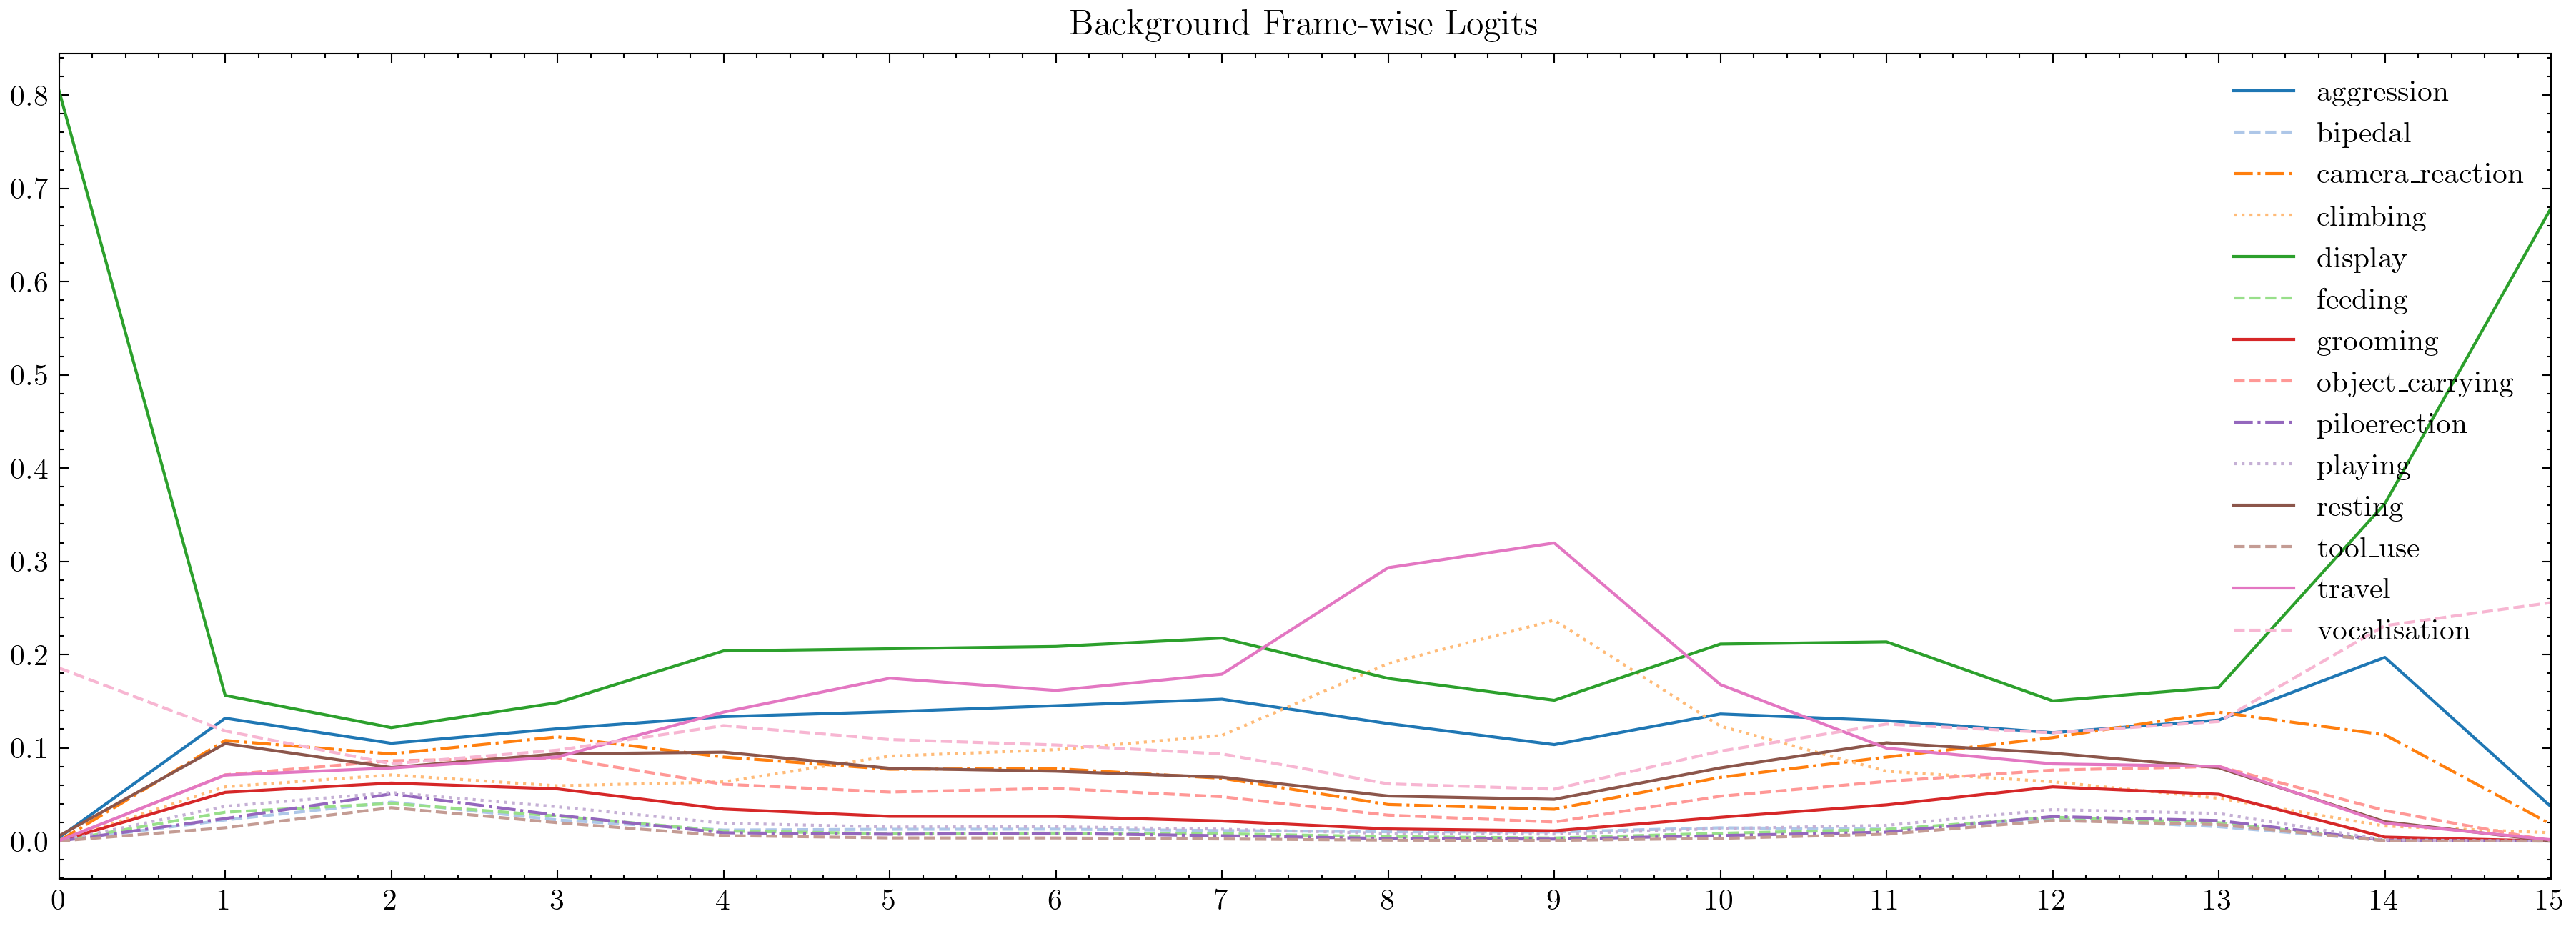

In [35]:
# divide the value of each element by the sum of the row
normalized_bg_frame_wise_logits = bg_frame_wise_logits / bg_column_sum[:, None]

# plot distribution of logits along 3rd dimension
plt.figure(figsize=(15, 5), dpi=300)

for i, beh in enumerate(behaviours):
    plt.plot(normalized_bg_frame_wise_logits[:, i], color=cmap[i], label=beh)

plt.title("Background Frame-wise Logits")
# add legend with behaviour names
plt.legend(behaviours, loc="upper right")

# add min max for x axis
plt.xlim(0, 15)
# add xtiks
plt.xticks(np.arange(0, 16, 1))
plt.show()

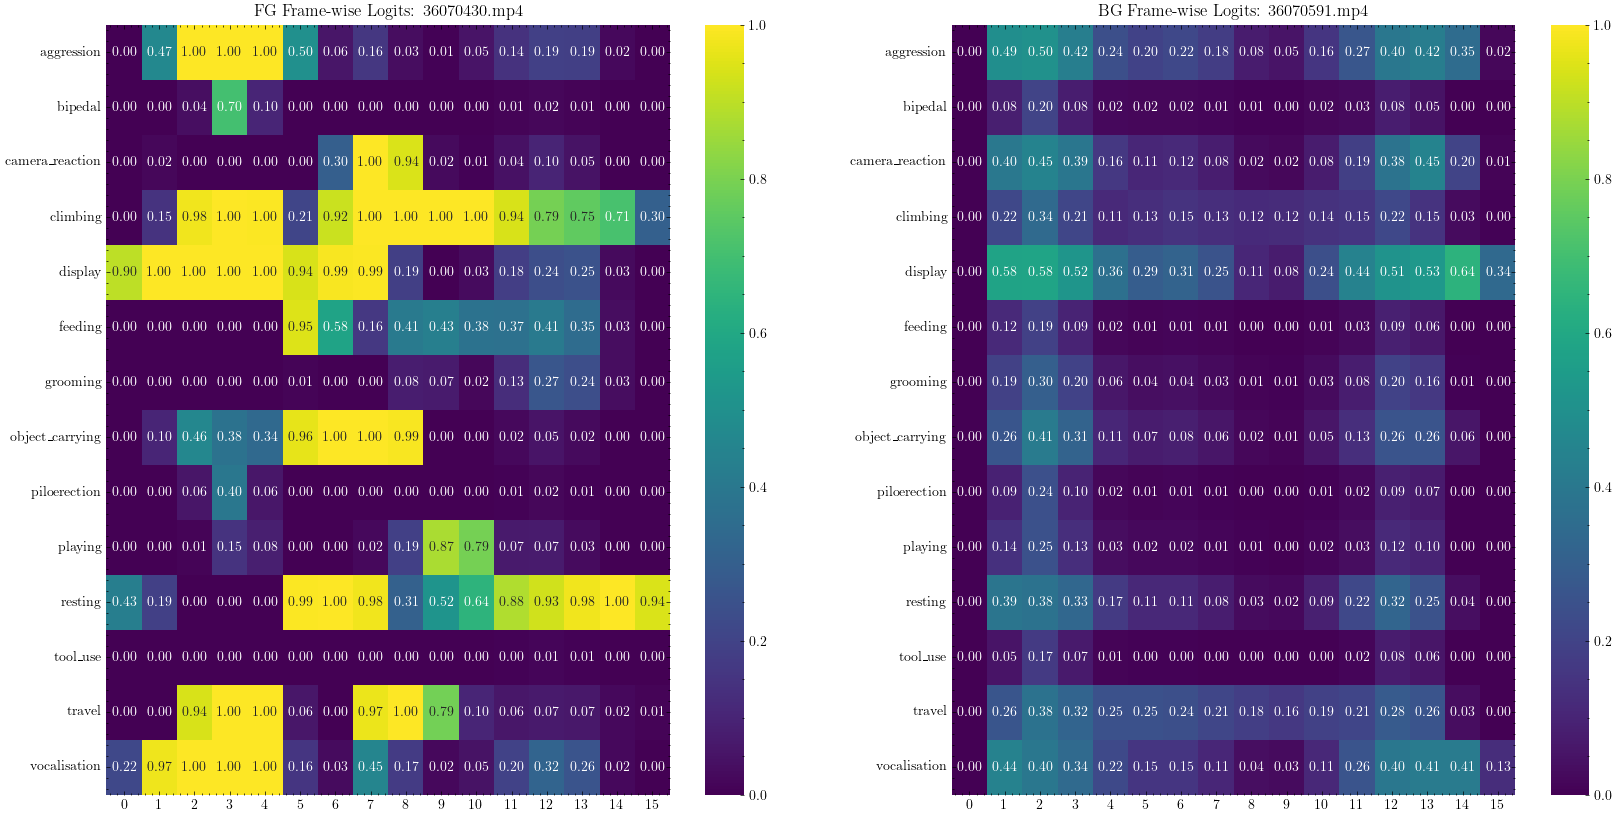

In [36]:
# Plot fg and bg frame-wise logits
fig, ax = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"width_ratios": [1, 1]})
sns.heatmap(
    fg_frame_wise_logits.T, cmap="viridis", annot=True, yticklabels=behaviours, ax=ax[0], vmin=0, vmax=1, fmt=".2f"
)
sns.heatmap(
    bg_frame_wise_logits.T, cmap="viridis", annot=True, yticklabels=behaviours, ax=ax[1], vmin=0, vmax=1, fmt=".2f"
)
ax[0].title.set_text(f"FG Frame-wise Logits: {fg_fewshot.name.iloc[sample_idx][0]}")
ax[1].title.set_text(f"BG Frame-wise Logits: {bg_fewshot.name.iloc[sample_idx][0]}")

### FG/BG Frame-wise Logits with swaped frames

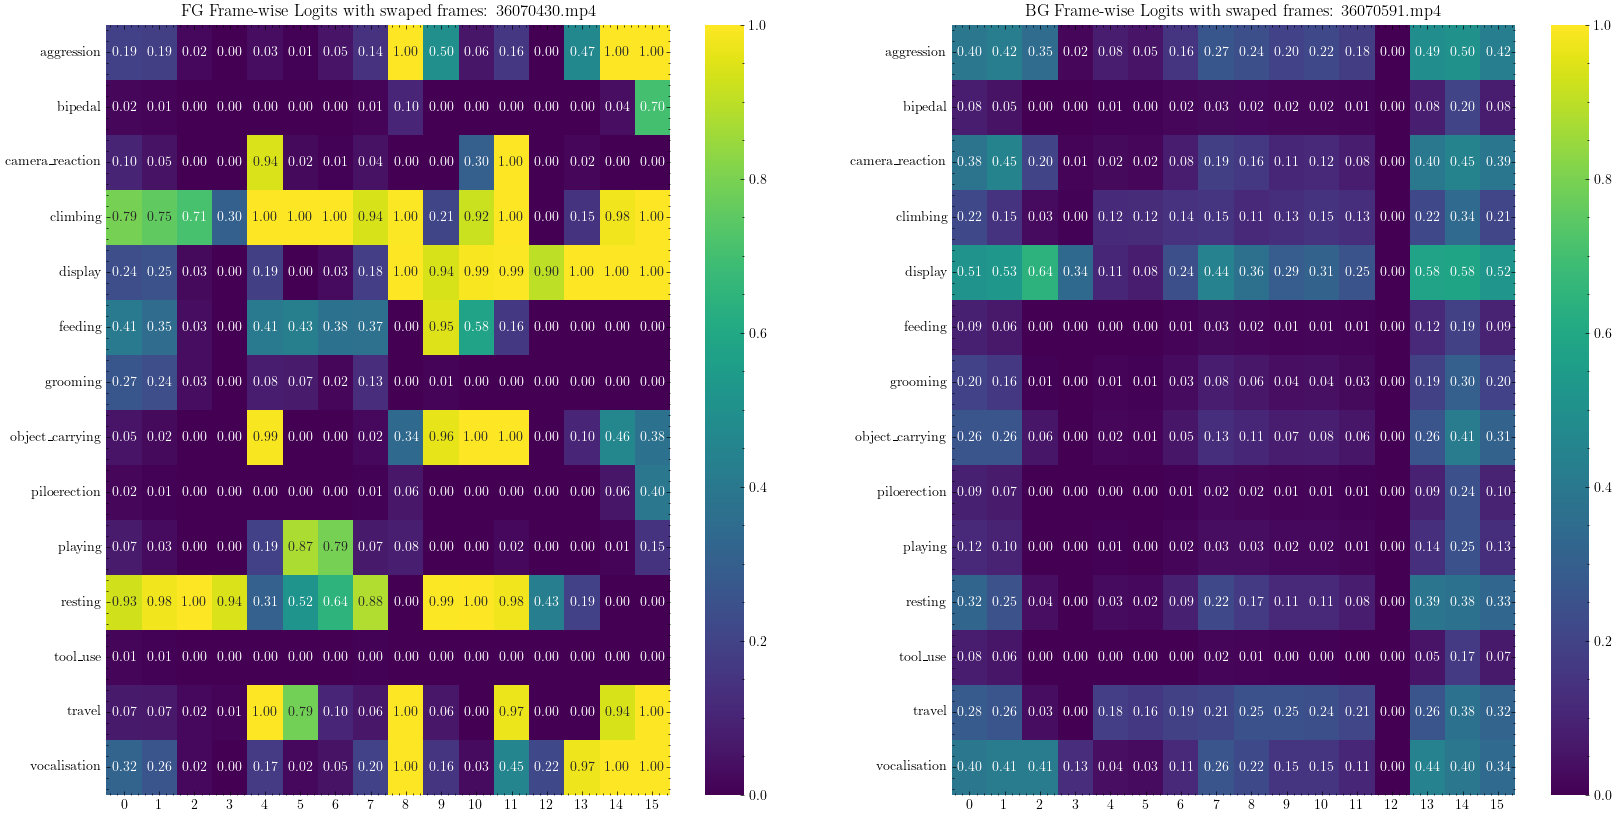

In [37]:
# Plot fg and bg frame-wise logits
fig, ax = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"width_ratios": [1, 1]})
sns.heatmap(
    fg_frame_wise_logits_swapped.T, cmap="viridis", annot=True, yticklabels=behaviours, ax=ax[0], vmin=0, vmax=1, fmt=".2f"
)
sns.heatmap(
    bg_frame_wise_logits_swapped.T, cmap="viridis", annot=True, yticklabels=behaviours, ax=ax[1], vmin=0, vmax=1, fmt=".2f"
)
ax[0].title.set_text(f"FG Frame-wise Logits with swaped frames: {fg_fewshot.name.iloc[sample_idx][0]}")
ax[1].title.set_text(f"BG Frame-wise Logits with swaped frames: {bg_fewshot.name.iloc[sample_idx][0]}")

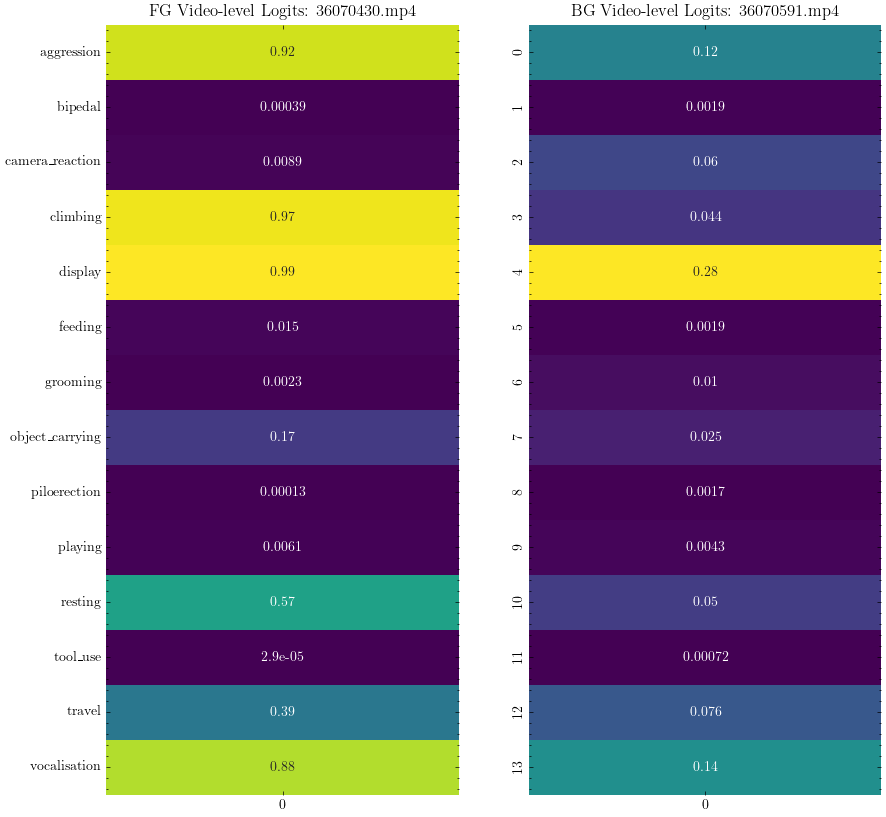

In [38]:
# Plot fg and bg video-level logits
fig, ax = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={"width_ratios": [1, 1]})

sns.heatmap(
    fg_video_level_logits.T,
    cmap="viridis",
    annot=True,
    ax=ax[0],
    cbar=False,
    yticklabels=behaviours,
)

sns.heatmap(
    bg_video_level_logits.T,
    cmap="viridis",
    annot=True,
    ax=ax[1],
    cbar=False,
)

ax[0].title.set_text(f"FG Video-level Logits: {fg_fewshot.name.iloc[sample_idx][0]}")
ax[1].title.set_text(f"BG Video-level Logits: {bg_fewshot.name.iloc[sample_idx][0]}")

### FG/BG Video-level Logits with swapped frames:

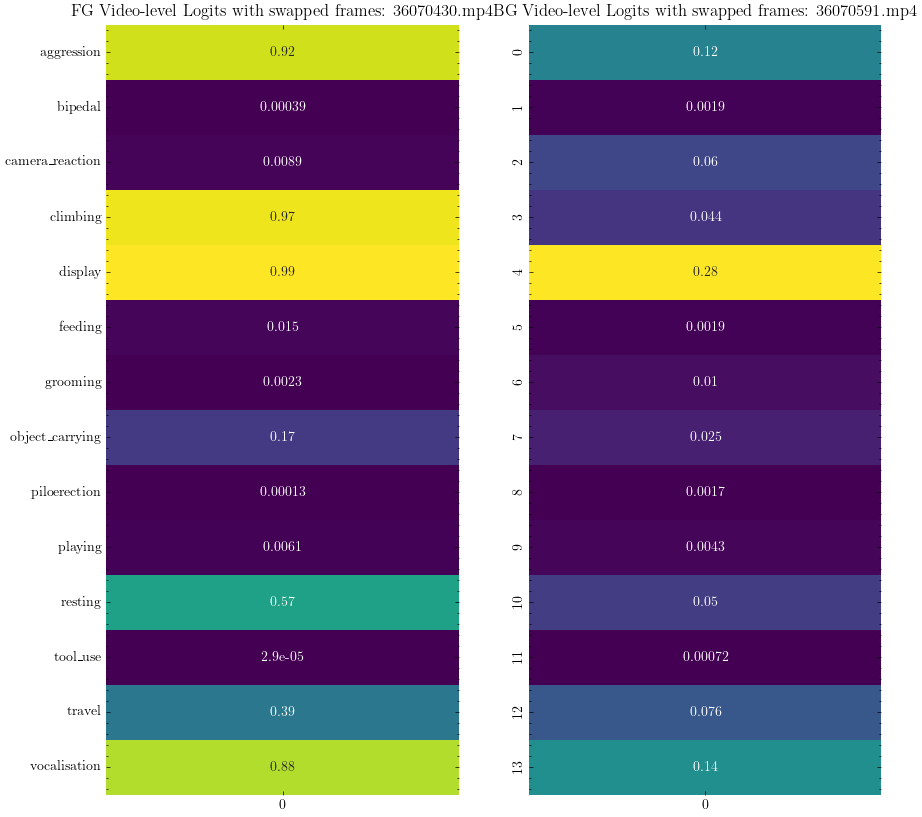

In [39]:
# Plot fg and bg video-level logits
fig, ax = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={"width_ratios": [1, 1]})

sns.heatmap(
    fg_video_level_logits_swapped.T,
    cmap="viridis",
    annot=True,
    ax=ax[0],
    cbar=False,
    yticklabels=behaviours,
)

sns.heatmap(
    bg_video_level_logits_swapped.T,
    cmap="viridis",
    annot=True,
    ax=ax[1],
    cbar=False,
)

ax[0].title.set_text(f"FG Video-level Logits with swapped frames: {fg_fewshot.name.iloc[sample_idx][0]}")
ax[1].title.set_text(f"BG Video-level Logits with swapped frames: {bg_fewshot.name.iloc[sample_idx][0]}")

In [40]:
fg_fewshot.name.iloc[sample_idx][0]

'36070430.mp4'